In [ ]:
!pip install sklearn
!pip install numpy
!pip install pandas
!pip install xgboost
!pip install seaborn
!pip install scipy
!pip install matplotlib

In [1]:
import numpy as np 
import pandas as pd 

# Importing Data

In [2]:
movies=pd.read_csv('data/movies.csv')
train=pd.read_csv('data/train.csv')
sample=pd.read_csv('data/sample.csv')
test=pd.read_csv('data/test.csv')

# Importing Libraries

In [3]:
import re
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,MultiLabelBinarizer,MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.metrics import f1_score,mean_squared_error,max_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from scipy.sparse import csr_matrix
import scipy.sparse as sp

import seaborn as sns
import matplotlib.pyplot as plt

# Cleaning and imputing data

> Cleaning, imputing and aggregating Movies data

> > Movie data's Cleaning and imputing section

In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


In [5]:
removal_column=['title','rating','ratingContents','releaseDateTheaters','releaseDateStreaming','boxOffice','distributor','soundType']
movies.drop(columns=removal_column,inplace=True)
movies.isnull().mean()*100

movieid              0.000000
audienceScore       48.869871
runtimeMinutes       9.651817
genre                7.736392
originalLanguage     9.673456
director             0.000000
dtype: float64

In [6]:
si_0_columns=['audienceScore','runtimeMinutes']
si_1_columns=['genre','director']
si_2_columns=['originalLanguage']

col_impute=ColumnTransformer([
    ('0_imputer',SimpleImputer(strategy='constant',fill_value=0),si_0_columns),
    ('blank_imputer',SimpleImputer(strategy='constant',fill_value=''),si_1_columns),
    ('english_imputer',SimpleImputer(strategy='constant',fill_value=''),si_2_columns),
],remainder='passthrough')

imputed_movies=pd.DataFrame(col_impute.fit_transform(movies))
imputed_movies.columns=['audienceScore','runtimeMinutes','genre','director','originalLanguage','movieid']
imputed_movies.isnull().mean()*100

audienceScore       0.0
runtimeMinutes      0.0
genre               0.0
director            0.0
originalLanguage    0.0
movieid             0.0
dtype: float64

In [7]:
imputed_movies.drop_duplicates(inplace=True)

> > Movie data aggregating section 

In [8]:
def split_comma_combine(List):
    final_list=[]
    for i in List:
        i=i.strip().split(',')
        for j in i:
            final_list.append(j)
    final_list=list(set(final_list))
    return final_list

def single_combine(List):
    final_list=[]
    for i in List:
        i=i.strip()
        if(i):
            final_list.append(i)
    final_list=list(set(final_list))
    return final_list

In [9]:
movies_aggregated=imputed_movies.groupby('movieid').agg({'audienceScore':['mean'],'runtimeMinutes':['median'],'genre':split_comma_combine,'originalLanguage':single_combine,'director':single_combine})
movies_aggregated.reset_index(inplace=True)
movies_aggregated.columns=movies.columns.tolist()
print(movies_aggregated.shape)
movies_aggregated.isnull().mean()*100

(126404, 6)


movieid             0.0
audienceScore       0.0
runtimeMinutes      0.0
genre               0.0
originalLanguage    0.0
director            0.0
dtype: float64

> Cleaning and imputing train data

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [11]:
train.isnull().mean()*100

movieid               0.000000
reviewerName          0.000000
isFrequentReviewer    0.000000
reviewText            3.961096
sentiment             0.000000
dtype: float64

In [12]:
def text_cleaner(text):
    ##Removes numerical values
    text=re.sub(r'\d+', '', text)
    url_pattern = r'https?://\S+|www\.\S+'
    text=re.sub(url_pattern, '', text)
    text=' '.join(word for word in text.split() if len(word) > 1)
    pattern = r"(.)\\1{2,}"
    text=re.sub(pattern, "\\1", text)
    return text

In [13]:
si_0_columns=['reviewText']

col_impute=ColumnTransformer([
    ('blank_imputer',SimpleImputer(strategy='constant',fill_value=''),si_0_columns),
],remainder='drop')

imputed_train=train.copy()

imputed_train['reviewText']=col_impute.fit_transform(imputed_train)
imputed_train['reviewText']=imputed_train['reviewText'].apply(text_cleaner)
imputed_train['sentiment']=imputed_train['sentiment'].map({'NEGATIVE':0,'POSITIVE':1})
imputed_train.isnull().mean()*100

movieid               0.0
reviewerName          0.0
isFrequentReviewer    0.0
reviewText            0.0
sentiment             0.0
dtype: float64

> Cleaning and imputing test data

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


In [15]:
test.isnull().mean()*100

movieid         0.000000
reviewerName    0.000000
isTopCritic     0.000000
reviewText      4.537648
dtype: float64

In [16]:
si_0_columns=['reviewText']

col_impute=ColumnTransformer([
    ('blank_imputer',SimpleImputer(strategy='constant',fill_value=''),si_0_columns),
],remainder='drop')

imputed_test=test.copy()

imputed_test['reviewText']=col_impute.fit_transform(imputed_test)
imputed_test['reviewText']=imputed_test['reviewText'].apply(text_cleaner)
imputed_test.isnull().mean()*100

movieid         0.0
reviewerName    0.0
isTopCritic     0.0
reviewText      0.0
dtype: float64

# Creating Merged Train and Test Sets and encoding features

> Train and movies merge

> > Creating Train and movies merge 

In [17]:
print(f'Train dataset shape {imputed_train.shape}')
print(f'Movies dataset shape {movies_aggregated.shape}')

Train dataset shape (162758, 5)
Movies dataset shape (126404, 6)


In [18]:
train_movie_merge=imputed_train.merge(movies_aggregated,on='movieid',how='left')
print(f'Shape of the merged train and movies dataset => {train_movie_merge.shape}')

Shape of the merged train and movies dataset => (162758, 10)


In [19]:
train_movie_merge.drop(columns=['movieid'],inplace=True)
train_movie_merge.isnull().mean()*100

reviewerName          0.0
isFrequentReviewer    0.0
reviewText            0.0
sentiment             0.0
audienceScore         0.0
runtimeMinutes        0.0
genre                 0.0
originalLanguage      0.0
director              0.0
dtype: float64

In [20]:
num_pipeline=Pipeline([
    ('selector_num',ColumnTransformer([
        ('select_num_attributes','passthrough',['audienceScore','runtimeMinutes'])
    ],remainder='drop')),
    ('scaling',MinMaxScaler())
])

> > Encoding the train and movies merge 

In [21]:
def train_preprocessing_data(dataframe):
    num_array=num_pipeline.fit_transform(dataframe)
    num_matrix=csr_matrix(num_array)
    print('Num Matrix Created')
    reviewerName=OneHotEncoder(handle_unknown='ignore')
    reviewerName_matrix=csr_matrix(reviewerName.fit_transform(np.array(dataframe['reviewerName']).reshape(-1,1)))
    print('ReviewerName one hot encoding done and encoder returned')
    isFrequentReviewer=OneHotEncoder(handle_unknown='ignore')
    isFrequentReviewer_matrix=csr_matrix(isFrequentReviewer.fit_transform(np.array(dataframe['isFrequentReviewer']).reshape(-1,1)))
    print('isFrequentReviewer one hot encoding done and encoder returned')
    director=MultiLabelBinarizer()
    director_matrix=csr_matrix(director.fit_transform(dataframe['director']))
    print('director MultiLabelBinaring done and binarizer returned')
    genre=MultiLabelBinarizer()
    genre_matrix=csr_matrix(genre.fit_transform(dataframe['genre']))
    print('genre MultiLabelBinaring done and binarizer returned')
    originalLanguage=MultiLabelBinarizer()
    originalLanguage_matrix=csr_matrix(originalLanguage.fit_transform(dataframe['originalLanguage']))
    print('originalLanguage MultiLabelBinaring done and binarizer returned')
    vectorizer = CountVectorizer()
    review_matrix = vectorizer.fit_transform(dataframe['reviewText'])
    print('Text Matrix Created')
    sentiment=dataframe['sentiment']
    print('Sentiment DF created')
    return(num_matrix,
           reviewerName,reviewerName_matrix,
           isFrequentReviewer,isFrequentReviewer_matrix,
           director,director_matrix,
           genre,genre_matrix,
           originalLanguage,originalLanguage_matrix,
           vectorizer,review_matrix,
           sentiment)

In [22]:
train_num_matrix,train_reviewerName,train_reviewerName_matrix,train_isFrequentReviewer,train_isFrequentReviewer_matrix,train_director,train_director_matrix,train_genre,train_genre_matrix,train_originalLanguage,train_originalLanguage_matrix,train_vectorizer,train_review_matrix,train_sentiment=train_preprocessing_data(train_movie_merge)

Num Matrix Created
ReviewerName one hot encoding done and encoder returned
isFrequentReviewer one hot encoding done and encoder returned
director MultiLabelBinaring done and binarizer returned
genre MultiLabelBinaring done and binarizer returned
originalLanguage MultiLabelBinaring done and binarizer returned
Text Matrix Created
Sentiment DF created


> > Creating Test and movies merge 

In [23]:
print(f'Tesy dataset shape {imputed_test.shape}')
print(f'Movies dataset shape {movies_aggregated.shape}')

Tesy dataset shape (55315, 4)
Movies dataset shape (126404, 6)


In [24]:
test_movie_merge=imputed_test.merge(movies_aggregated,on='movieid',how='left')
print(f'Shape of the merged train and movies dataset => {test_movie_merge.shape}')

Shape of the merged train and movies dataset => (55315, 9)


In [25]:
test_movie_merge.drop(columns=['movieid'],inplace=True)
test_movie_merge.isnull().mean()*100

reviewerName        0.0
isTopCritic         0.0
reviewText          0.0
audienceScore       0.0
runtimeMinutes      0.0
genre               0.0
originalLanguage    0.0
director            0.0
dtype: float64

> > Encoding the test and movies merge 

In [26]:
def test_preprocessing_data(dataframe,reviewName_fit,isFrequent_Fit,train_director_fit,genre_fit,originalLanguage_fit,train_reviewtext_vectorizer):
    num_array=num_pipeline.fit_transform(dataframe)
    num_matrix=csr_matrix(num_array)
    print('Num Matrix Created')
    reviewerName_matrix=csr_matrix(reviewName_fit.transform(np.array(dataframe['reviewerName']).reshape(-1,1)))
    print('reviewName matrix created')
    isFrequentReviewer_matrix=csr_matrix(isFrequent_Fit.transform(np.array(dataframe['isTopCritic']).reshape(-1,1)))
    print('isFrequent/TopCritic matrix created')
    director_matrix=csr_matrix(train_director_fit.transform(dataframe['director']))
    print('Director Matrix Created')
    genre_matrix=csr_matrix(genre_fit.transform(dataframe['genre']))
    print('genre Matrix Created')
    originalLanguage_matrix=csr_matrix(originalLanguage_fit.transform(dataframe['originalLanguage']))
    print('originalLanguage Matrix Created')
    review_matrix = train_reviewtext_vectorizer.transform(dataframe['reviewText'])
    print('Text Matrix Created')
    return(num_matrix,
           reviewerName_matrix,
           isFrequentReviewer_matrix,
           director_matrix,
           genre_matrix,
           originalLanguage_matrix,
           review_matrix)

In [27]:
test_num_matrix,test_reviewerName_matrix,test_isFrequentReviewer_matrix,test_director_array_matrix,test_genre_matrix,test_originalLanguage_matrix,test_review_matrix=test_preprocessing_data(test_movie_merge,train_reviewerName,train_isFrequentReviewer,train_director,train_genre,train_originalLanguage,train_vectorizer)

Num Matrix Created
reviewName matrix created
isFrequent/TopCritic matrix created


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Alice Jennings', 'Alice Rodman', 'Amy Cooper', 'Andrew Remillard', 'Anthony Mccraken', 'April Black', 'Barry Currence', 'Becky Randall', 'Bonnie Morel', 'Bradford Cronin', 'Carl Bowden', 'Carla Chitwood', 'Carlos Mason', 'Carlos Talley', 'Charles Burks', 'Cheryl Wade', 'David Fryberger', 'Debbie Moy', 'Diana Coates', 'Donald Stitt', 'Donna Torres', 'Dorathy Cozzolino', 'Elizabeth Mosley', 'Evan Sewell', 'Floyd Jennins', 'Frederick Titcomb', 'Gary Meyer', 'George Harris', 'Gerald Bagwell', 'Harlan Stapleton', 'Harry Carter', 'Helen Stump', 'Janice Fox', 'Jeff Parker', 'Jenna Ford', 'Jennifer Speer', 'Jocelyn Jones', 'Jose Adkins', 'Juliette Montoya', 'Karina Abbott', 'Katherine Mullin', 'Kimberly Kay', 'Kristina Kelly', 'Lawrence Galvan', 'Lynn Clark', 'Mandie Filippini', 'Margaret Jacobson', 'Maria Swoope', 'Mary Sines', 'Miguel Usher', 'Misti Smith', 'Nellie Mcgray', 'Nestor S

Director Matrix Created
genre Matrix Created
originalLanguage Matrix Created
Text Matrix Created


In [28]:
sp.hstack([test_num_matrix,test_reviewerName_matrix,test_isFrequentReviewer_matrix,test_director_array_matrix,test_genre_matrix,test_originalLanguage_matrix,test_review_matrix])

<55315x82166 sparse matrix of type '<class 'numpy.float64'>'
	with 1558671 stored elements in Compressed Sparse Row format>

In [29]:
sp.hstack([train_num_matrix,train_reviewerName_matrix,train_isFrequentReviewer_matrix,train_director_matrix,train_genre_matrix,train_originalLanguage_matrix,train_review_matrix])

<162758x82166 sparse matrix of type '<class 'numpy.float64'>'
	with 4657558 stored elements in Compressed Sparse Row format>

# EDA

**Note:**
1 Represent : 'POSITIVE'
0 Represent : 'NEGATIVE'

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


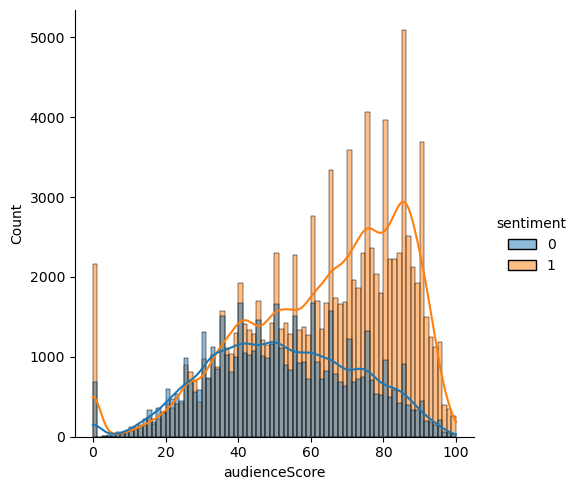

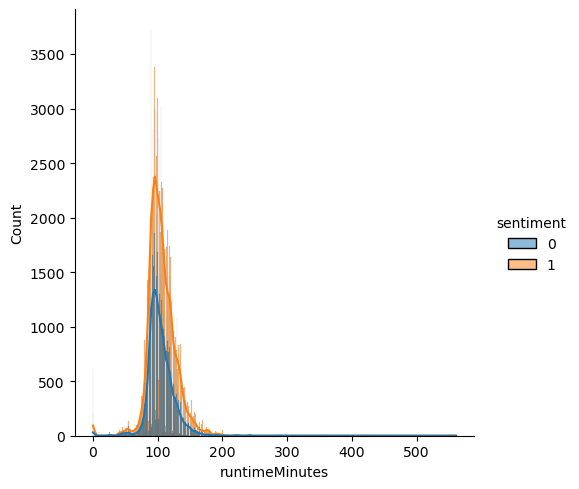

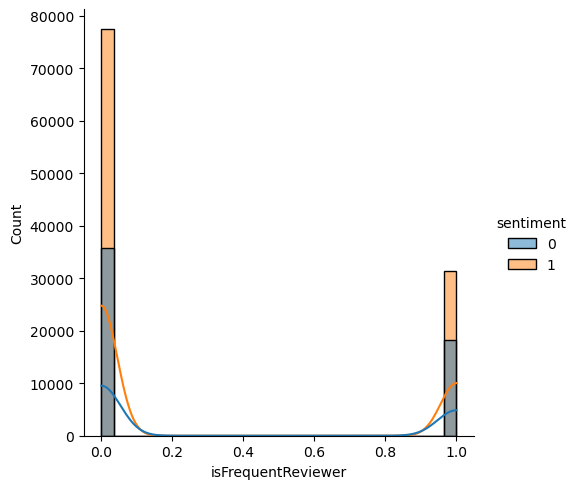

In [30]:
sns.displot(data=train_movie_merge,x='audienceScore',hue='sentiment',kde=True)
sns.displot(data=train_movie_merge,x='runtimeMinutes',hue='sentiment',kde=True)
sns.displot(data=train_movie_merge,x='isFrequentReviewer',hue='sentiment',kde=True)

From the above graphs the following conclusions can be drawn.
* AudienceScore has somewhat overlap with sentiment prediction. The implication of this overalapping however can be reduced if the number of features used for prediction are increased
* Similar for runtiemMinutes
* Negative Reviews are signifacntly more than the positive review, therefore prediction of the negative sentimented review is going to be more efficient than the positive sentimented reviewtext

**Let's shift our focus to the relevant feature [reviewText]**

In the below section we will find the Top 10 most frequent words occuring inside a 'POSITIVE' and 'NEGATIVE' classified reviewText

Steps followed to achieve this are:
1. Drop all the rows having null value in the reviewText Column
2. Clean the reviewText Column
3. Apply CountVectorization on the reviewText to fit the model on it.
4. Fit LogisticRegression on the model.
5. The coef_ will give the probabiltiy of each feature on the regressionfitted model
6. We the sorts the coef_ in ascending order using argsort and take features indexes from opposite position depending if we are finding for negative or positive sentiment
7. Identify the feature names from the CountVectorizer sparse matrix using the indexes obtained from 6th step.
8. Similarly we use this sparse matrix to get the occurence of these features too.

In [31]:
def text_cleaner(text):
    ##Removes numerical values
    text=re.sub(r'\d+', '', text)
    url_pattern = r'https?://\S+|www\.\S+'
    text=re.sub(url_pattern, '', text)
    text=' '.join(word for word in text.split() if len(word) > 1)
    pattern = r"(.)\\1{2,}"
    text=re.sub(pattern, "\\1", text)
    return text

In [32]:
text_train_movie_join=pd.DataFrame(train_movie_merge[['reviewText','sentiment']])
text_train_movie_join.dropna(inplace=True)
text_train_movie_join['reviewText']=text_train_movie_join['reviewText'].apply(text_cleaner)
text_train_movie_join.isnull().sum()*100

reviewText    0
sentiment     0
dtype: int64

In [33]:
train_text_vectorizer=CountVectorizer()
train_text_sparse=train_text_vectorizer.fit_transform(text_train_movie_join['reviewText'])

In [34]:
lr=LogisticRegression(max_iter=1000)
lr.fit(train_text_sparse,text_train_movie_join['sentiment'])

LogisticRegression(max_iter=1000)

In [35]:
train_text_sparse_feature_name=train_text_vectorizer.get_feature_names_out()

In [36]:
positive_sentiment_coef = lr.coef_[0]
top_positive_features_indices = positive_sentiment_coef.argsort()[-20:][::-1]
top_positive_features = [train_text_sparse_feature_name[index] for index in top_positive_features_indices]
top_positive_features_freq = [train_text_sparse[:, index].sum() for index in top_positive_features_indices]

negative_sentiment_coef = lr.coef_[0]
top_negative_features_indices = negative_sentiment_coef.argsort()[:20]
top_negative_features = [train_text_sparse_feature_name[index] for index in top_negative_features_indices]
top_negative_features_freq = [train_text_sparse[:, index].sum() for index in top_negative_features_indices]

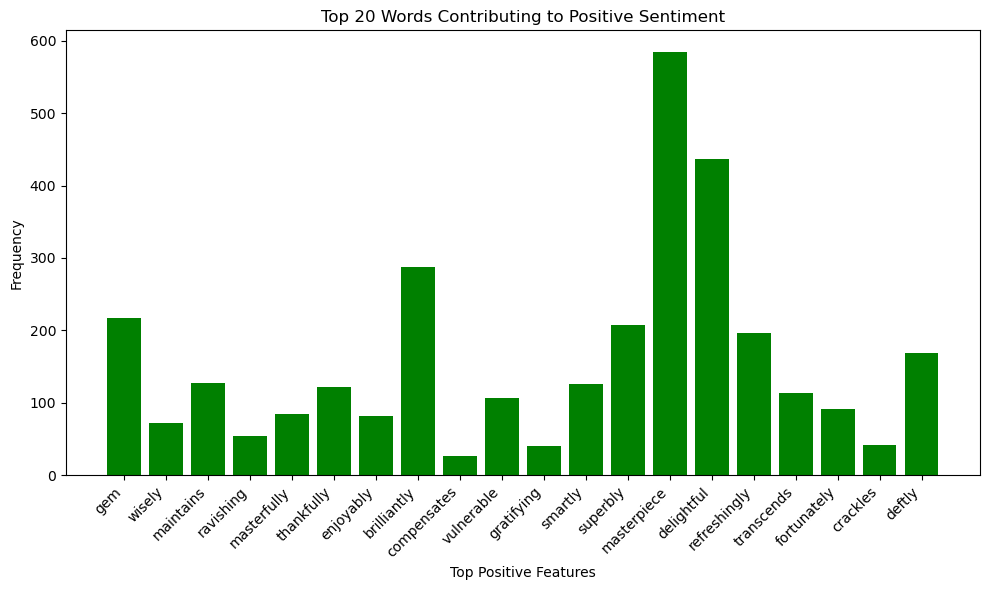

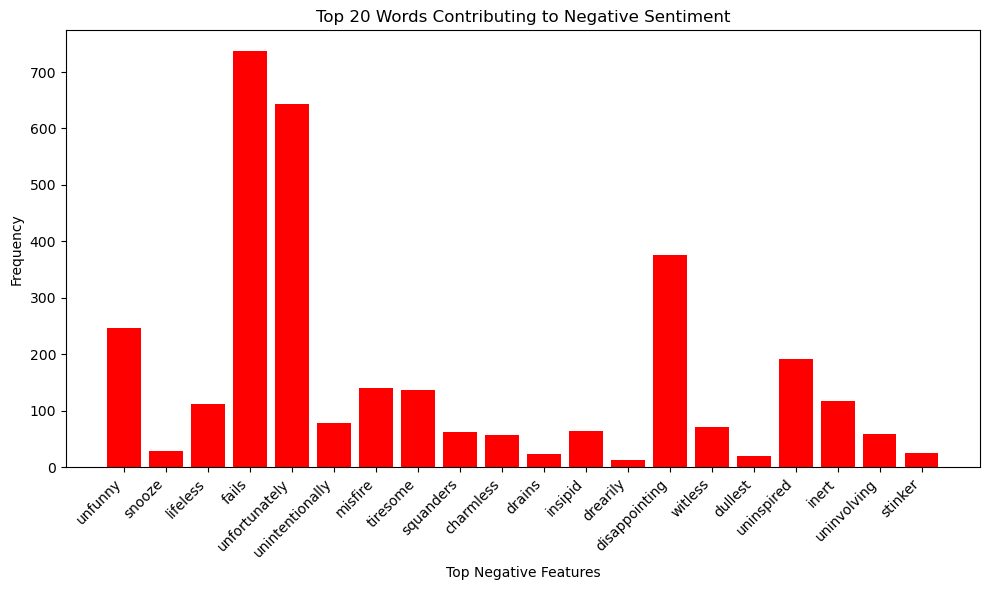

In [37]:
# Bar graphs for top positive features and their frequencies.
plt.figure(figsize=(10, 6))
plt.bar(top_positive_features, top_positive_features_freq, color='green')
plt.xlabel('Top Positive Features')
plt.ylabel('Frequency')
plt.title('Top 20 Words Contributing to Positive Sentiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Bar graphs for top negative features and their frequencies.
plt.figure(figsize=(10, 6))
plt.bar(top_negative_features, top_negative_features_freq, color='red')
plt.xlabel('Top Negative Features')
plt.ylabel('Frequency')
plt.title('Top 20 Words Contributing to Negative Sentiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The below heatmap shows the correlation of all the indiviual genre with the sentiment column and it concludes that no single genre or small group of them can be used for predicting the sentiment.

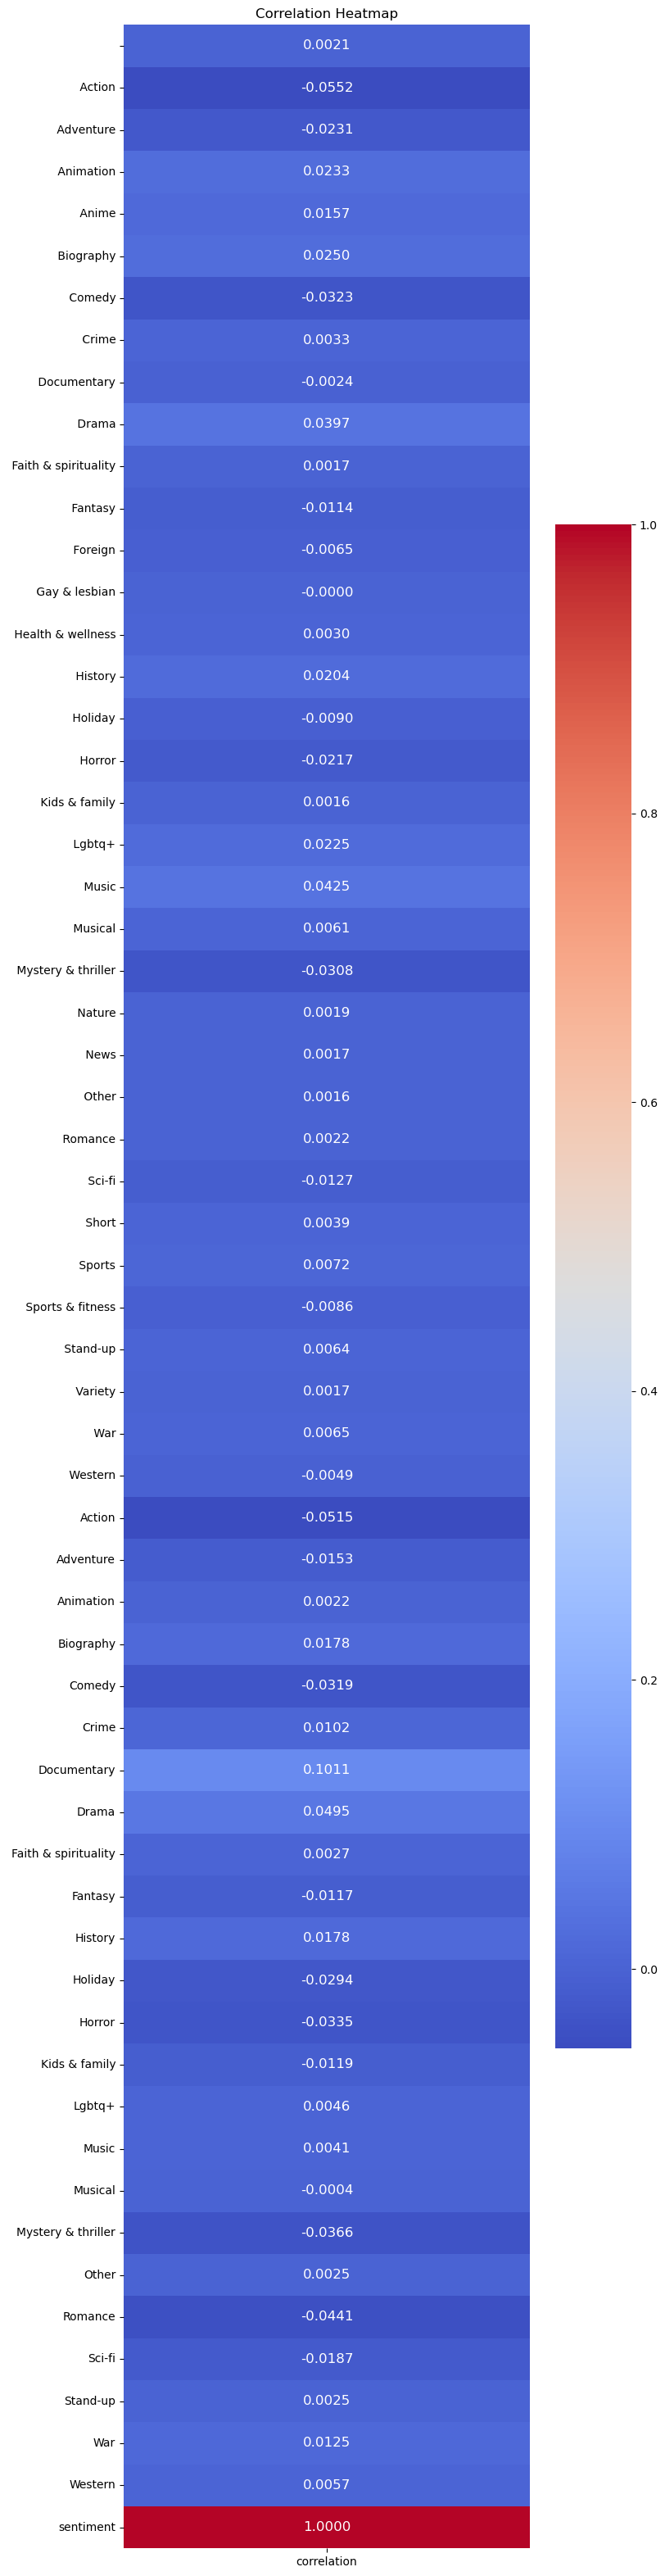

In [38]:
genre=pd.DataFrame(train_genre_matrix.toarray(),columns=train_genre.classes_)
sentiment=pd.DataFrame(train_sentiment)
merged_genre_sentiment=pd.concat([genre,sentiment],axis=1)

correlation=merged_genre_sentiment.corr()['sentiment']

corr_df=pd.DataFrame(correlation)
corr_df.columns=['correlation']

plt.figure(figsize=(8, 40))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.4f', annot_kws={"size": 12})
plt.title("Correlation Heatmap")
plt.show()

# Model Selection

In [39]:
train_final_data=sp.hstack([train_num_matrix,train_reviewerName_matrix,train_isFrequentReviewer_matrix,train_director_matrix,train_genre_matrix,train_originalLanguage_matrix,train_review_matrix])
test_final_data=sp.hstack([test_num_matrix,test_reviewerName_matrix,test_isFrequentReviewer_matrix,test_director_array_matrix,test_genre_matrix,test_originalLanguage_matrix,test_review_matrix])

In [40]:
def training_classifier_for_comparison(estimator,feature,label,cv,scoring):
    result=cross_validate(estimator,feature,label,cv=cv,scoring=scoring,return_train_score=True)
    print(f'{estimator} gives train f1_score of {result["train_f1"].mean()}')
    print(f'{estimator} gives test f1_score of {result["test_f1"].mean()}')
    print(f'{estimator} gives train neg_mean_square_error of {result["train_neg_mean_squared_error"].mean()}')
    print(f'{estimator} gives test neg_mean_square_error of {result["test_neg_mean_squared_error"].mean()}')  
    print(f'{estimator} gives the test accuracy of {result["test_accuracy"].mean()}')

**Below is the output when cv is setup to 5 for the below code**

Logistic Regression ----------------------------------------------

LogisticRegression(max_iter=1000) gives train f1_score of 0.9393761057973311

LogisticRegression(max_iter=1000) gives test f1_score of 0.8718929777528344

LogisticRegression(max_iter=1000) gives train neg_mean_square_error of -0.08222048139102653

LogisticRegression(max_iter=1000) gives test neg_mean_square_error of -0.17532563283362007

LogisticRegression(max_iter=1000) gives the test accuracy of 0.8246743671663801

MultinomialNB ----------------------------------------------------

MultinomialNB() gives train f1_score of 0.8937051414517935

MultinomialNB() gives test f1_score of 0.8528839947252207

MultinomialNB() gives train neg_mean_square_error of -0.141174753851589

MultinomialNB() gives test neg_mean_square_error of -0.1960493978864586

MultinomialNB() gives the test accuracy of 0.8039506021135414

LinearSVC --------------------------------------------------------

LinearSVC(C=1) gives train f1_score of 0.969170405892718

LinearSVC(C=1) gives test f1_score of 0.8502048521933974

LinearSVC(C=1) gives train neg_mean_square_error of -0.041365221264765065

LinearSVC(C=1) gives test neg_mean_square_error of -0.2018616367657901

LinearSVC(C=1) gives the test accuracy of 0.7981383632342098

XGBoost --------------------------------------------------------

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) gives train f1_score of 0.8591498613625257

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) gives test f1_score of 0.8436852673084939

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) gives train neg_mean_square_error of -0.20351596700612876

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) gives test neg_mean_square_error of -0.2270521012533792

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) gives the test accuracy of 0.7729478987466207

In [41]:
cv=ShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
scoring=["f1","neg_mean_squared_error","accuracy"]

print("Logistic Regression ----------------------------------------------")
training_classifier_for_comparison(LogisticRegression(max_iter=1000),train_final_data,train_sentiment,cv,scoring)
print("MultinomialNB ----------------------------------------------------")
training_classifier_for_comparison(MultinomialNB(),train_final_data,train_sentiment,cv,scoring)
print("LinearSVC --------------------------------------------------------")
training_classifier_for_comparison(LinearSVC(C=1,max_iter=1000),train_final_data,train_sentiment,cv,scoring)
print("XGBoost --------------------------------------------------------")
training_classifier_for_comparison(XGBClassifier(),train_final_data,train_sentiment,cv,scoring)

Logistic Regression ----------------------------------------------
LogisticRegression(max_iter=1000) gives train f1_score of 0.9394737587447249
LogisticRegression(max_iter=1000) gives test f1_score of 0.8695769213513392
LogisticRegression(max_iter=1000) gives train neg_mean_square_error of -0.08206227055588836
LogisticRegression(max_iter=1000) gives test neg_mean_square_error of -0.1786065372327353
LogisticRegression(max_iter=1000) gives the test accuracy of 0.8213934627672647
MultinomialNB ----------------------------------------------------
MultinomialNB() gives train f1_score of 0.8938862860778529
MultinomialNB() gives test f1_score of 0.8522303549233532
MultinomialNB() gives train neg_mean_square_error of -0.14089980492450424
MultinomialNB() gives test neg_mean_square_error of -0.1972229048906365
MultinomialNB() gives the test accuracy of 0.8027770951093635
LinearSVC --------------------------------------------------------


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1) gives train f1_score of 0.969193512374693
LinearSVC(C=1) gives test f1_score of 0.8492688926342641
LinearSVC(C=1) gives train neg_mean_square_error of -0.041326820576624734
LinearSVC(C=1) gives test neg_mean_square_error of -0.20330548046202998
LinearSVC(C=1) gives the test accuracy of 0.79669451953797
XGBoost --------------------------------------------------------
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_const

* We would continue working with logisitcRegression as it is the most accurate

# Selected Model hyperparameter tuning

In [42]:
# logreg_grid = {"penalty":['l1','l2']
#                 "solver": ["liblinear","saga"]}

# GS_logreg = GridSearchCV(LogisticRegression(),
#                           param_grid=logreg_grid,
#                           cv=5,
#                           verbose=True)

# # Fit grid hyperparameter search model
# GS_logreg.fit(train_final_data, train_sentiment)
# GS_logreg.best_params_
# GS_logreg.score(train_final_data,train_sentiment)

* The above code will be used to do the hyperparameter tuning but for the sake of time restriction we will be using the below code for prediction
* We will also be increasing the number of features in the reviewText matrix to increase the accuracy

# Final Prediciton

In [43]:
text_train_movie_join=pd.DataFrame(train_movie_merge[['reviewText','sentiment']])
text_train_movie_join.dropna(inplace=True)
text_train_movie_join['reviewText']=text_train_movie_join['reviewText'].apply(text_cleaner)
text_train_movie_join.isnull().sum()*100

train_text_vectorizer=CountVectorizer(ngram_range=(1,3))
train_text_sparse=train_text_vectorizer.fit_transform(text_train_movie_join['reviewText'])

test_review_matrix = train_text_vectorizer.transform(test_movie_merge['reviewText'])

train_final_data=sp.hstack([train_num_matrix,train_reviewerName_matrix,train_isFrequentReviewer_matrix,train_director_matrix,train_genre_matrix,train_originalLanguage_matrix,train_text_sparse])
test_final_data=sp.hstack([test_num_matrix,test_reviewerName_matrix,test_isFrequentReviewer_matrix,test_director_array_matrix,test_genre_matrix,test_originalLanguage_matrix,test_review_matrix])

In [44]:
lr=LogisticRegression(max_iter=1000)

In [45]:
lr.fit(train_final_data,train_sentiment)

LogisticRegression(max_iter=1000)

In [46]:
lr.score(train_final_data,train_sentiment)

0.9921478514112978

In [47]:
train_prediction=lr.predict(train_final_data)

# Prediction Evaluation

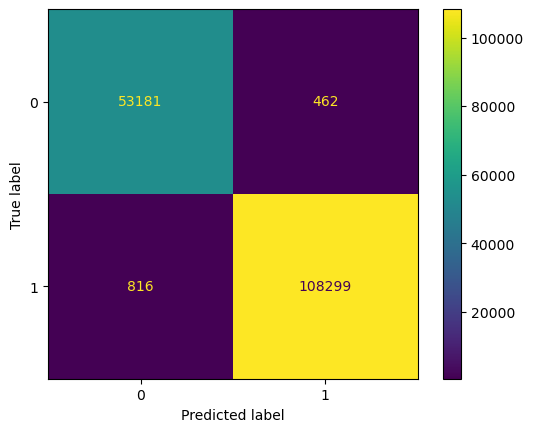

In [48]:
lr_cm=confusion_matrix(train_prediction, train_sentiment,labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm,display_labels=lr.classes_)
disp.plot()

In [49]:
CR = classification_report(train_prediction, train_sentiment)
print('Classification report \n')
print(CR)

Classification report 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     53643
           1       1.00      0.99      0.99    109115

    accuracy                           0.99    162758
   macro avg       0.99      0.99      0.99    162758
weighted avg       0.99      0.99      0.99    162758



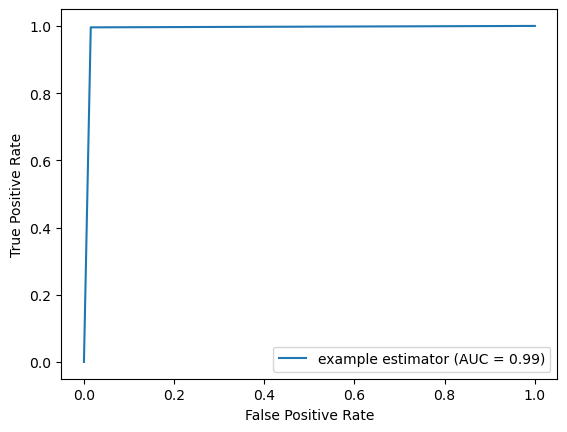

In [50]:
# Plot ROC curve and calculate AUC metric
fpr, tpr, thresholds = roc_curve(train_sentiment, train_prediction)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()
plt.show()

# Submission

This is for kaggle competition

In [51]:
test_prediction=lr.predict(test_final_data)
test_prediction=pd.DataFrame(test_prediction)
test_prediction.columns=['sentiment']
test_prediction['sentiment']=test_prediction['sentiment'].map({0:'NEGATIVE',1:'POSITIVE'})
test_prediction

,sentiment
0,POSITIVE
1,POSITIVE
2,POSITIVE
3,POSITIVE
4,POSITIVE
...,...
55310,POSITIVE
55311,NEGATIVE
55312,NEGATIVE
55313,POSITIVE


In [52]:
submission=pd.DataFrame(columns=['id','sentiment'])
submission['id']=[i for i in range(len(test_prediction['sentiment']))]
submission['sentiment']=test_prediction['sentiment']
submission.to_csv('submission.csv',index=False)